## Train Network
This file trains a network according to a selected configuration (dataset, OSR, parameters, ..).


In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable

import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

import glob
import os
import _pickle as pickle

# import externally defined network structures and data loaders
import auxiliary as aux

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# select a GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
pid  = os.getpid()

cuda:0


### Select training configuration

In [16]:
conf_name = 'linear_layer_u_hat_6_bits'
try:
    c = aux.conf[conf_name]
    print('config "%s" selected. available checkpoints: ' % conf_name)
    print('\n'.join(sorted(glob.glob('./Networks/%s.ckp*' % conf_name), key=os.path.getmtime)))
except:
    print('config %s not available! (available configs: %s)' % (conf_name, aux.conf.keys()))

config "linear_layer_u_hat_6_bits" selected. available checkpoints: 
./Networks/linear_layer_u_hat_6_bits.ckp#2
./Networks/linear_layer_u_hat_6_bits.ckp#3
./Networks/linear_layer_u_hat_6_bits.ckp#1


### Load model from disk or create new one

In [20]:
#### specify checkpoint to load or leave empty if no checkpoint shall be loaded
ckp_fname = '' # 'first_random_noise_test.ckp#9460' 
# ckp_fname = sorted(glob.glob('./Networks/%s*' % conf_name), key=os.path.getmtime)[-1].split('/')[2] # take most recent one


# define empty network, optimizer and loss function
net = c['network']().double().to(device)
optimizer = optim.SGD(net.parameters(), lr=c['learning_rate'], momentum=c['momentum'])
criterion = nn.MSELoss()
epoch_offset = 0

# if checkpoint available, load state
if ckp_fname: 
    try:
        state = torch.load('./Networks/' + ckp_fname)
        net.load_state_dict(state['network_dict'])
        optimizer.load_state_dict(state['optimizer_dict'])
        epoch_offset = state['epoch']
        print('checkpoint "%s" loaded' % ckp_fname)
    except Exception as e:
        print('loading of checkpoint failed! (%s)' % e)
else:
    print('network created')

network created


### Select and load dataset, create data loader

In [21]:
# trainig data set
print("loading dataset from file ..")
ds_load_train = pickle.load(open('./Datasets/' + c['dataset_train'], 'rb', -1))

params_train = {'batch_size': c['batch_size'], 'shuffle': True, 'num_workers': 8}
ds_train = aux.DatasetStream(ds_load_train['y'], ds_load_train['x'], c)
data_loader_train = data.DataLoader(ds_train, **params_train) # a data loader is a data set and a sampler
print("loading done. length of data set: %i samples" % ds_train.__len__())

loading dataset from file ..
loading done. length of data set: 999901 samples


### Iterate through data set and train network

<IPython.core.display.Javascript object>


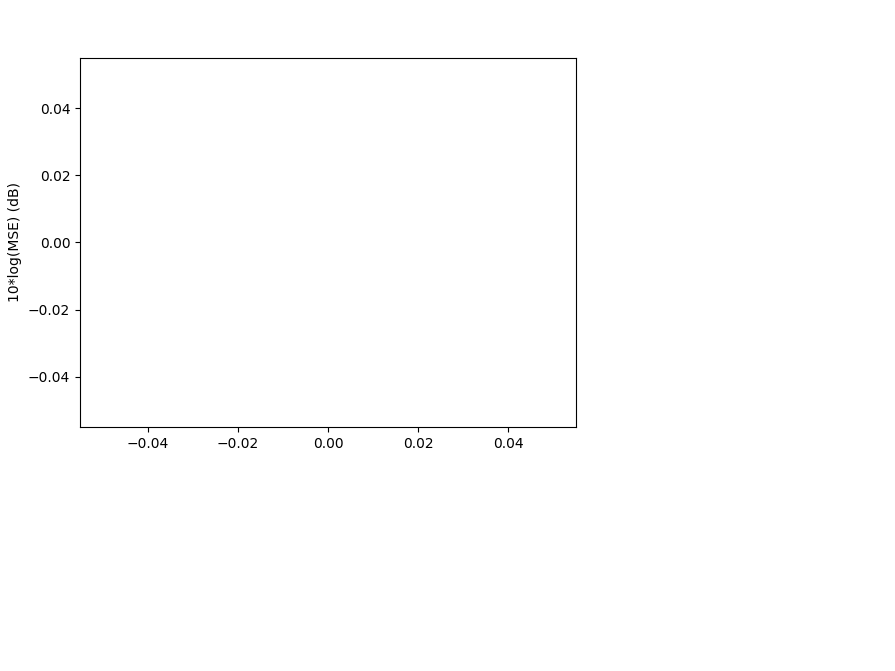

PID: 11511, epoch: 1, MSE_train: nan (nan dB)


Process Process-64:
Process Process-61:
Process Process-59:
Traceback (most recent call last):
Process Process-60:
  File "/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-62:
Traceback (most recent call last):
  File "/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-63:
Traceback (most recent call last):
Process Process-57:
  File "/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  

KeyboardInterrupt: 

  File "/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
Traceback (most recent call last):
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "

In [22]:
n_epochs = 100000 # how many additional epochs?
n_iter_per_batch = 5 # numbers of iteration per batch
n_snapshot = 1

mses_train = np.zeros(n_epochs)
mses_train[0] = 0

fig, ax = plt.subplots(1,1)
ax.plot(mses_train)
ax.set_ylabel('10*log(MSE) (dB)')


for epoch in range(n_epochs):
    epoch_total = epoch_offset + epoch + 1

    mse_train_sum = 0.0
    n_of_mses = 0

    for i, (batch_data, batch_labels) in enumerate(data_loader_train): 
        # train each batch multiple times
        batch_data = Variable(batch_data.double()).cuda(async=True)
        batch_labels = Variable(batch_labels.double()).cuda(async=True)

        for i_batch in range(n_iter_per_batch):
            # train network
            optimizer.zero_grad()
            outputs = net(batch_data).view(-1)
#             print(outputs)
            loss = criterion(outputs, batch_labels)
            loss.backward()        
            optimizer.step()
            mse_train_sum += loss.data.item()
            n_of_mses += 1
#     del batch_data, batch_labels, outputs
    
    # validate with test data set
    mse_train = mse_train_sum / n_of_mses
    mses_train[epoch] = mse_train

    print('PID: %i, epoch: %i, MSE_train: %.10f (%.5f dB)' 
                % (pid, epoch_total, mse_train, 10*np.log10(mse_train)))


    # plot live loss function
    for line in ax.lines:
        line.set_ydata(10*np.log10(mses_train[0:epoch + 1]))
        line.set_xdata( range(epoch_offset + 1, epoch_offset + epoch + 2))
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw()
    

    # take snapshot
    if (epoch + 1) % n_snapshot == 0:
        # save plot
        fig.savefig('./Plots/%s.png' % conf_name, bbox_inches='tight')
        # saving network
        state = {'epoch': epoch_total, 'network_dict': net.state_dict(), 'optimizer_dict': optimizer.state_dict() }
        torch.save(state, './Networks/%s.ckp#%i' % (conf_name, epoch_total))   
        
print("Finished training...")